In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              79 non-null     int64  
 1   company                 79 non-null     object 
 2   time                    79 non-null     object 
 3   debt_ratio              79 non-null     float64
 4   return_on_equity_ratio  79 non-null     float64
 5   current_ratio           79 non-null     float64
 6   return_on_asset_ratio   79 non-null     float64
 7   debt_to_equity_ratio    79 non-null     float64
 8   EPS                     22 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 5.7+ KB


In [4]:
data=data.drop(columns='Unnamed: 0')
data=data[data.time!='2023-03-30'].reset_index(drop=True)

In [5]:
data=data.groupby(by=['company'],as_index=False).mean()

In [6]:
data_string=data[['company','EPS']]
data_num=data.drop(columns=['company','EPS'])

In [7]:
#Function to get weight from entropy
def weight_based_on_entropy(data):
    #Normalization of negative data
    for col in data_num.columns:
        if np.min(data_num[col]) < 0:
            minimum = data[col].min()
            data_num[col]=data_num[col].transform(lambda X: X-minimum)
        else:
            continue
        
    #Create table calculation of pij
    pij=pd.DataFrame(columns=data_num.columns)
    for col in data_num.columns:
        pij[col]=data_num[col]/np.sum(data_num[col])
    
    #Calculate entropy
    entropy=pd.DataFrame(columns=pij.columns)
    for col in pij.columns:
        entropy[col]=pij[col]*np.log(pij[col])
    for col in entropy.columns:
        entropy[col]=-(1/np.log(len(entropy[col])))*np.sum(entropy[col])
    entropy=entropy.iloc[0]
    
    #calculate weight
    weight=pd.Series(index=entropy.index)
    for i in weight.index:
        weight[i]=1-entropy[i]
    weight_final=pd.Series(index=weight.index)
    for i in weight.index:
        weight_final[i]=weight[i]/np.sum(weight)
    return weight_final

    #Calculate distance and performance
    distance_matrix=pd.DataFrame(columns=['Distance_Positive',
                                          'Distance_Negative',
                                          'Performance_Score'],
                                 index=data_num2.index)
    

In [8]:
weight=weight_based_on_entropy(data_num)

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/j8/y_9b3dcx03nct600zgv3jf_80000gn/T/ipykernel_6332/3627909253.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  weight=pd.Series(index=entropy.index)
/var/folders/j8/y_9b3dcx03nct600zgv3jf_80000gn/T/ipykernel_6332/3627909253.py:28: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  weight_final=pd.Series(index=weight.index)


In [9]:
weight

debt_ratio                0.154547
return_on_equity_ratio    0.052824
current_ratio             0.278944
return_on_asset_ratio     0.133824
debt_to_equity_ratio      0.379861
dtype: float64

<AxesSubplot:>

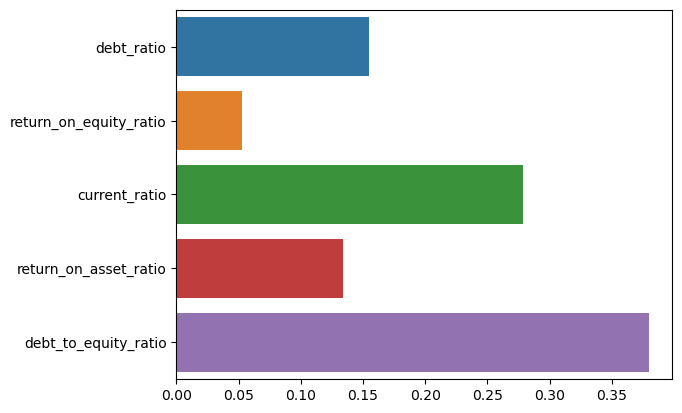

In [10]:
sns.barplot(x=weight.values, y=weight.index)

Calculate TOPSIS

In [24]:
data_num2=data.drop(columns=['company','EPS'])

In [56]:
def create_rank_TOPSIS(data,weight):
    #Normalization of data
    for col in data.columns:
        sum_square = 0
        for i in data.index:
            sum_square +=(data[col][i])**2
        data[col]=data[col].map(lambda x: x/sum_square)
    
    #Calculate weight normalized matrix
    weight_top=pd.DataFrame(columns=data.columns)
    for col in weight_top.columns:
        weight_top[col]=data[col].map(lambda x: x* weight[col])
        
    #Create array of ideal best and ideal worst
    ideal_best=pd.Series(index=weight_top.columns)
    ideal_worst=pd.Series(index=weight_top.columns)
    low_better=['debt_to_equity_ratio','debt_ratio']
    high_better=['current_ratio','return_on_asset_ratio','return_on_equity_ratio']
    for i in weight_top.columns:
        if i in low_better:
            ideal_best[i]=weight_top[i][weight_top[i]>0].min()
            ideal_worst[i]=weight_top[i].max()
        elif i in high_better:
            ideal_best[i]=weight_top[i].max()
            ideal_worst[i]=weight_top[i].min()
    array_ideal_best=np.array(ideal_best)
    array_ideal_worst=np.array(ideal_worst)
    
   
    #Create distance matrix
    distance_matrix=pd.DataFrame(columns=['Distance_Positive','Distance_Negative','Performance_Score'],index=data.index)
    for i in data.index:
        distance_matrix['Distance_Positive'].iloc[i]=np.linalg.norm(data.iloc[i].to_numpy() - array_ideal_best)
        distance_matrix['Distance_Negative'].iloc[i]=np.linalg.norm(data.iloc[i].to_numpy() - array_ideal_worst)
        distance_matrix['Performance_Score'].iloc[i]=distance_matrix['Distance_Negative'].iloc[i]/(distance_matrix['Distance_Negative'].iloc[i]+distance_matrix['Distance_Positive'].iloc[i])
    
    return distance_matrix, array_ideal_best, array_ideal_worst, weight_top, ideal_best, ideal_worst


In [57]:
distance,array_ideal_best, array_ideal_worst,weight_top,ideal_best, ideal_worst=create_rank_TOPSIS(data_num2,weight)

/var/folders/j8/y_9b3dcx03nct600zgv3jf_80000gn/T/ipykernel_6332/3752317204.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ideal_best=pd.Series(index=weight_top.columns)
/var/folders/j8/y_9b3dcx03nct600zgv3jf_80000gn/T/ipykernel_6332/3752317204.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ideal_worst=pd.Series(index=weight_top.columns)


In [58]:
new_data=pd.concat([data,distance],axis=1)

In [15]:
new_data=new_data.drop(columns=['Distance_Positive','Distance_Negative'])
new_data=new_data[new_data.company != 'UNSP.JK']

In [638]:
new_data.to_csv('performance_score.csv',index=False)

In [61]:
new_data.sort_values(by='Performance_Score',ascending=False)

,company,debt_ratio,return_on_equity_ratio,current_ratio,return_on_asset_ratio,debt_to_equity_ratio,EPS,Distance_Positive,Distance_Negative,Performance_Score
14,SIMP.JK,0.437815,0.018329,1.095477,0.008173,0.985045,19.00,0.110258,1.056498,0.905501
2,ANJT.JK,0.318664,0.012500,1.836498,0.008348,0.470688,0.00,0.116969,1.071034,0.901542
7,GZCO.JK,0.420252,0.016854,0.647611,0.009084,0.757111,2.00,0.189445,1.142373,0.857755
19,TBLA.JK,0.697218,0.029497,1.273769,0.008872,2.308437,37.89,0.188354,1.128042,0.856917
21,UNSP.JK,2.003963,-0.012835,0.120180,0.010216,-2.388410,9.80,0.34423,1.25244,0.784408
12,PSGO.JK,0.593851,0.030257,2.426777,0.012313,1.462733,5.07,0.4995,1.454381,0.744355
0,AALI.JK,0.293741,0.020333,2.138517,0.014044,0.430200,251.18,0.658443,1.615533,0.710444
11,MKTR.JK,0.690026,0.047489,0.881168,0.014607,2.243360,0.76,0.724482,1.678597,0.698519
20,TLDN.JK,0.595643,0.044513,1.278406,0.017924,1.474804,NaN,1.035944,1.992354,0.657912
5,DSNG.JK,0.486866,0.040554,1.085464,0.020545,0.966428,19.31,1.283641,2.240461,0.635754
